# Particle movement in a simple model of a tokamak

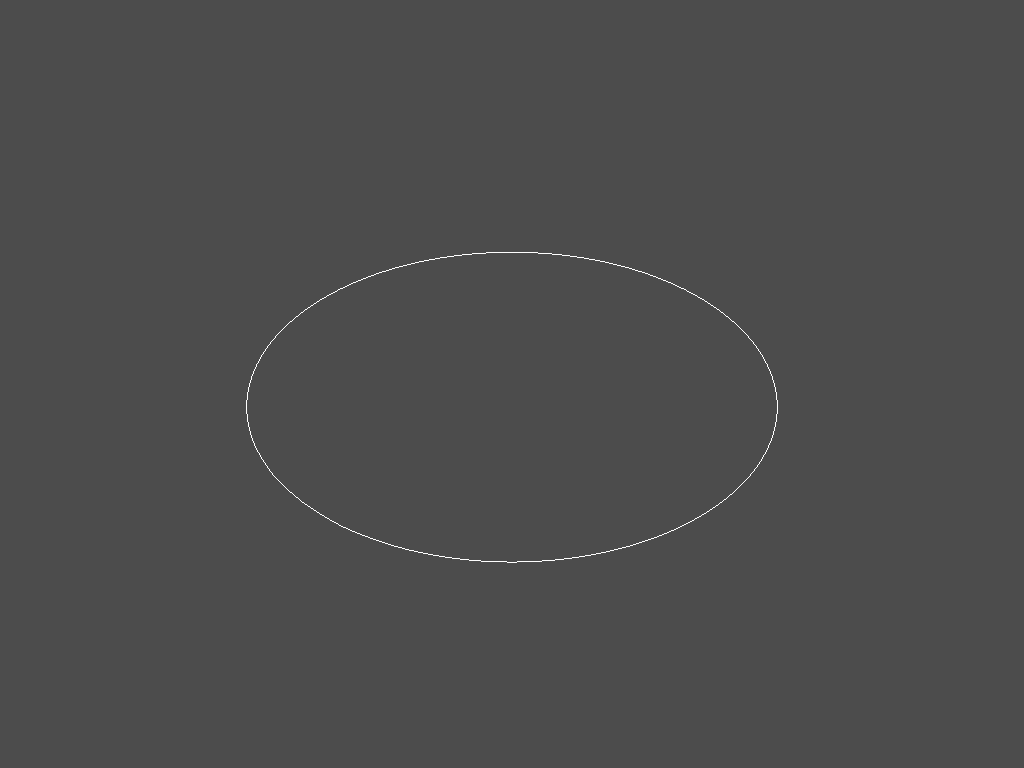

In [1]:
%autoreload 2
from plasmapy import simulation
from plasmapy.formulary import magnetostatics
from plasmapy.classes.sources import Coils
import astropy.units as u
import numpy as np
radius = 0.5 * u.m
main_current = 4 * u.kA
plasma_wire = magnetostatics.CircularWire([0, 0, 1], u.Quantity((0, 0, 0), u.m), radius, main_current)
plasma_wire.visualize().show()

That's supposed to model just the plasma; let's add a few coils:

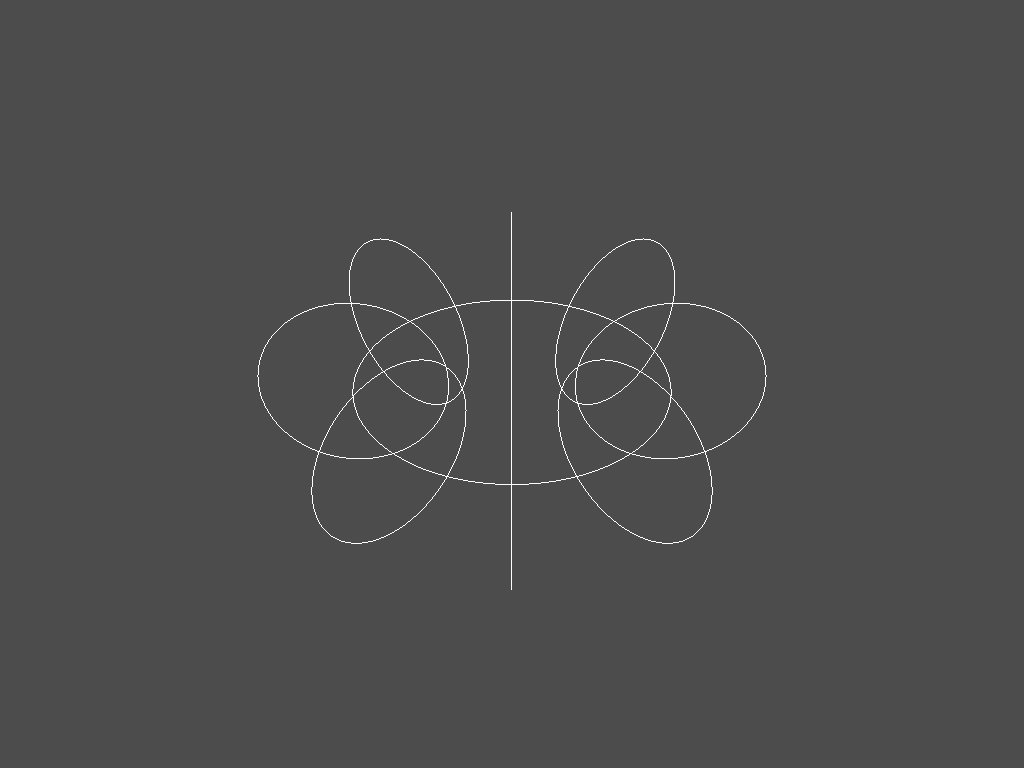

In [2]:
n_coils = 8
currents = n_coils * [4 * u.kA]

coil_angles = np.linspace(0, 2*np.pi, n_coils, endpoint=False)
coil_angles
minor_radius = 0.3 * u.m

poloidal_coils = []
for i in range(n_coils):
    coil_angle = coil_angles[i]
    x = radius * np.cos(coil_angle)
    y = radius * np.sin(coil_angle)
    normal_angle = np.pi/2 + coil_angle
    normal = u.Quantity([np.cos(normal_angle), np.sin(normal_angle), 0])
    center = u.Quantity([x, y, 0 * u.m])
    coil = magnetostatics.CircularWire(normal, center, minor_radius, currents[i])
    poloidal_coils.append(coil)
all_currents = poloidal_coils + [plasma_wire]
coils = c = Coils(*all_currents) # TODO rename to coils
coils.visualize().show()

Note that a shortcut for this model can be quickly accessed as `Coils.toykamak`.

Let's add a proton. We'll put it at $x = 0.6 \text{m}$, directly in the central YZ plane, and we'll give it a very nonrelativistic velocity of 300m/s in the Y direction.

In [3]:
x = u.Quantity([[0.6, 0, 0]],  u.m)
v = u.Quantity([[0, 300, 0]], u.m / u.s)

initial_condition = simulation.ParticleTracker(c, x, v, 'p',)
initial_condition

ParticleTracker(plasma=Coils(9 x CircularWire(4000.0 A)), particle_type=p+, N = 1)

Let's run the simulation for 0.1s. We'll use a timestep of $10 \mu \text{s}$.

In [4]:
solution = initial_condition.run(1e-1 * u.s, dt = 1e-5 * u.s)
solution

<xarray.Dataset>
Dimensions:         (dimension: 3, particle: 1, time: 1001)
Coordinates:
  * time            (time) float64 0.0 0.00011 0.00021 ... 0.09981 0.09991 0.1
  * particle        (particle) int64 0
  * dimension       (dimension) <U1 'x' 'y' 'z'
Data variables:
    position        (time, particle, dimension) float64 0.6 0.0 ... -0.03678
    velocity        (time, particle, dimension) float64 -64.52 217.3 ... -86.12
    B               (time, particle, dimension) float64 1.084e-19 ... -0.004752
    E               (time, particle, dimension) float64 0.0 0.0 0.0 ... 0.0 0.0
    timestep        (time) float64 1e-05 1e-05 1e-05 1e-05 ... 1e-05 1e-05 1e-05
    kinetic_energy  (time, particle) float64 7.527e-23 7.527e-23 ... 7.527e-23
Attributes:
    particle:          p+
    total_iterations:  10001

The result is an `xarray.Dataset`. We can visualize the simulation using methods in the `particletracker` xarray accessor, which should be getting registered on using anything from the `particletracker` module:

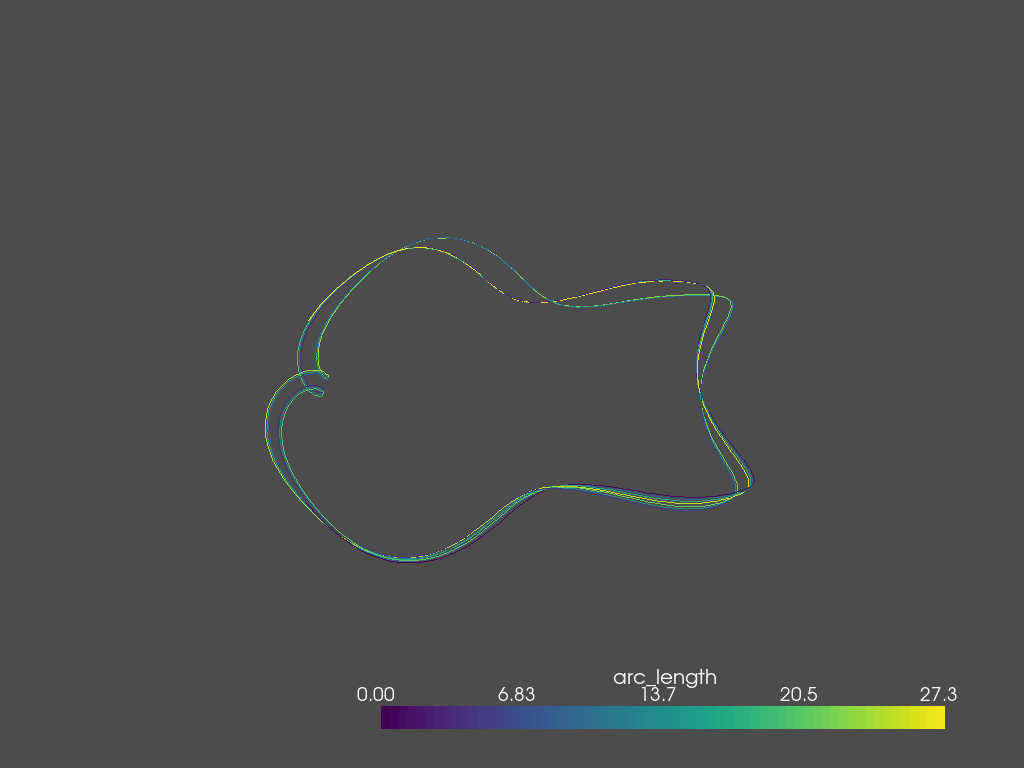

In [8]:
solution.particletracker.visualize().show()

We can also pass the plasma to the visualizer to see where the trajectory is relative to the coils:

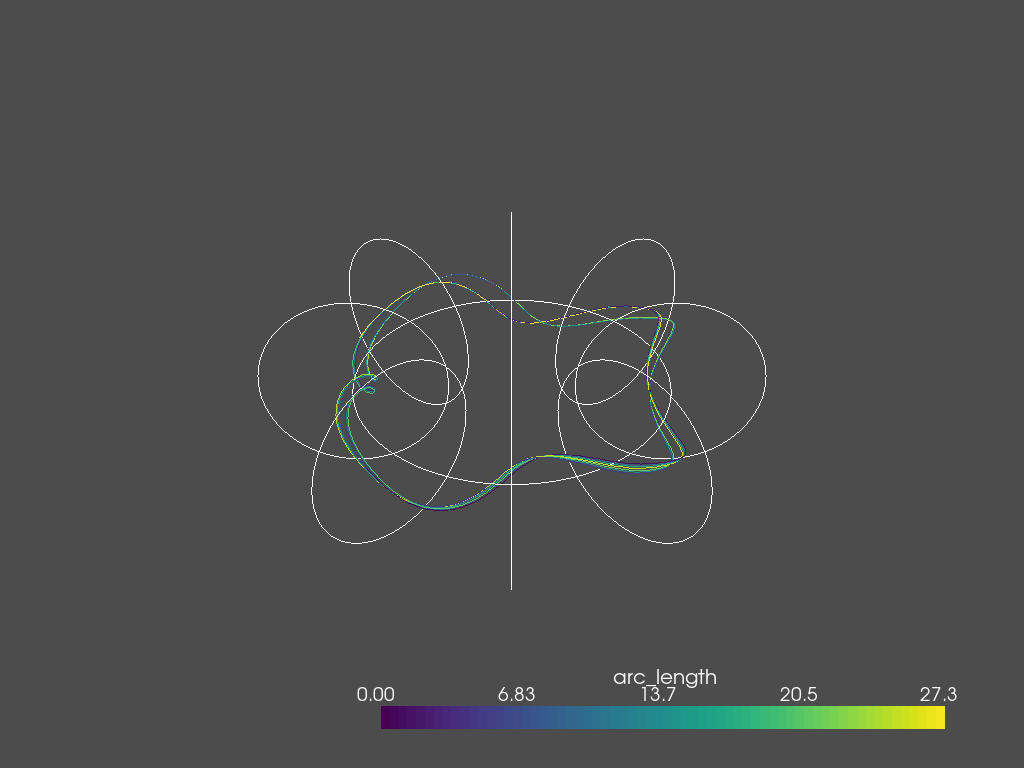

In [9]:
solution.particletracker.visualize(plasma=c).show()

In [10]:
# # use this locally to get cool interactive plots!
# import pyvista as pv
# solution.particletracker.visualize(pv.BackgroundPlotter(), plasma=c).show()

Since the solution is an `xarray`, we can use the usual `xarray` syntax. The `particletracker` accessor also contains a helpful `vector_norm` method. For example, the following code lets us see the sampled magnitude of the magnetic field:

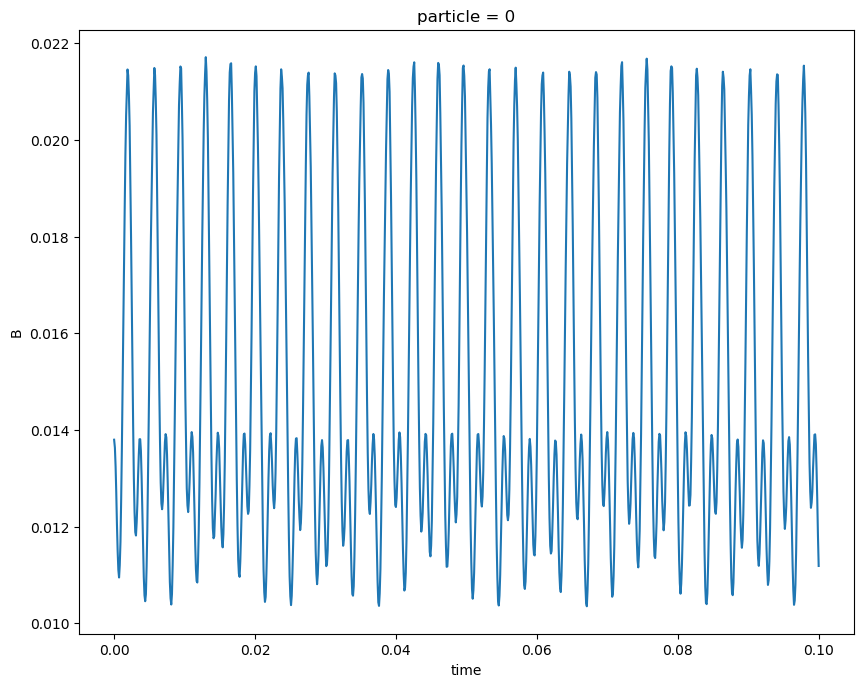

In [11]:
solution.sel(particle=0).particletracker.vector_norm('B').plot.line();

We can use that to estimate the gyrofrequency the particle experiences, and see how badly we estimated the timestep:

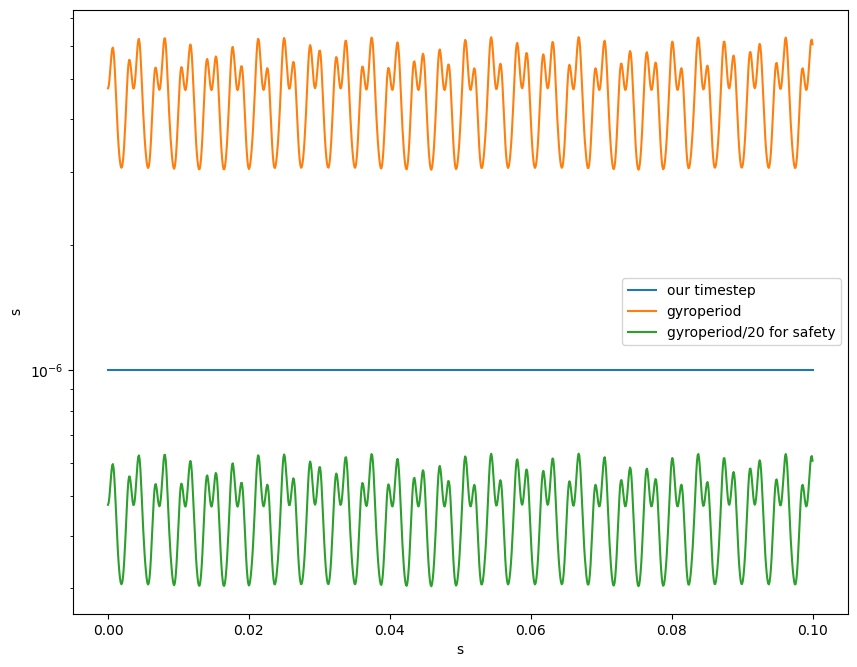

In [30]:
from plasmapy.formulary import gyrofrequency

gyrofreq = gyrofrequency(
    u.Quantity(solution.sel(particle=0).particletracker.vector_norm('B'), 'T'),
    solution.particletracker.particle, to_hz = True)

gyroperiod = (1 / gyrofreq).si

from astropy.visualization import quantity_support
with quantity_support():
    plt.plot(u.Quantity(solution.time, 's'), solution.timestep, label="our timestep")
    plt.plot(u.Quantity(solution.time, 's'), gyroperiod, label="gyroperiod")
    plt.plot(u.Quantity(solution.time, 's'), gyroperiod/10, label="gyroperiod/20 for safety")
plt.yscale('log')
plt.legend(loc='best');

Well, looks like we underestimated the timestep we'd need to have for stability in this case! [It's a remarkable thing about the default Boris integrator PlasmaPy uses that the orbits still close decently well despite the long timestep.](https://aip.scitation.org/doi/abs/10.1063/1.4818428?journalCode=php) Let's go with a timestep of 1 $\mu s$ instead. On my laptop this takes about ten minutes and is a perfect opportunity to grab some tea.

Speed-up contributions are most welcome!

In [27]:
solution = initial_condition.run(1e-1 * u.s, dt = 1e-6 * u.s)
solution

<xarray.Dataset>
Dimensions:         (dimension: 3, particle: 1, time: 1001)
Coordinates:
  * time            (time) float64 0.0 0.000101 0.000201 ... 0.0998 0.0999 0.1
  * particle        (particle) int64 0
  * dimension       (dimension) <U1 'x' 'y' 'z'
Data variables:
    position        (time, particle, dimension) float64 0.6 0.0 ... -0.0746
    velocity        (time, particle, dimension) float64 -69.33 291.1 ... 14.5
    B               (time, particle, dimension) float64 1.084e-19 ... -0.003155
    E               (time, particle, dimension) float64 0.0 0.0 0.0 ... 0.0 0.0
    timestep        (time) float64 1e-06 1e-06 1e-06 1e-06 ... 1e-06 1e-06 1e-06
    kinetic_energy  (time, particle) float64 7.527e-23 7.527e-23 ... 7.527e-23
Attributes:
    particle:          p+
    total_iterations:  100000

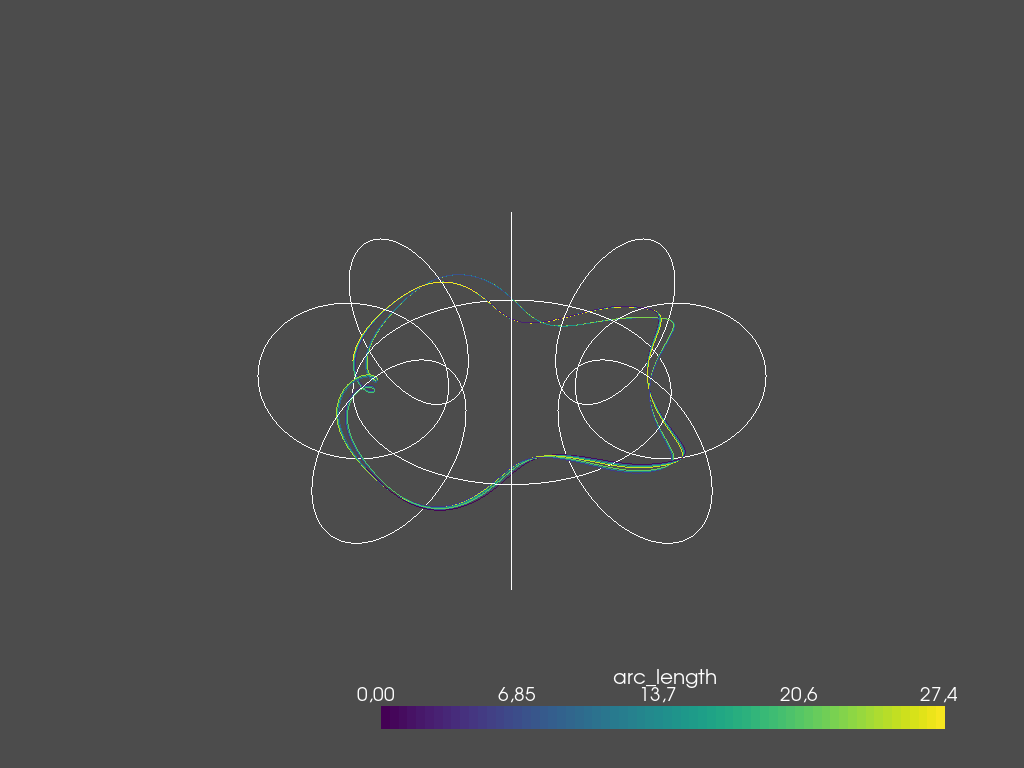

In [29]:
solution.particletracker.visualize(plasma=c).show()

We can also animate this motion, save it to MP4 and display it within the notebook. Depending on the number of frames in your simulation, this might take a while.

Note how the particle's velocity vector wobbles - it's the gyroorbit precession! (I think.)

In [31]:
solution.particletracker.animate("toykamak.mp4", nframes = 1000, notebook_display = True, plasma=c)

Let's take a look at the same trajectory for an electron. Since timescales for electrons will generally be shorter than for protons, we'll adjust and shorten the simulation run. We'll also let PlasmaPy adjust the timestep on its own.

In [79]:
solution_electron = simulation.ParticleTracker(c, x, v, 'e-').run(1e-1 * u.s, dt = 1e-6 * u.s)

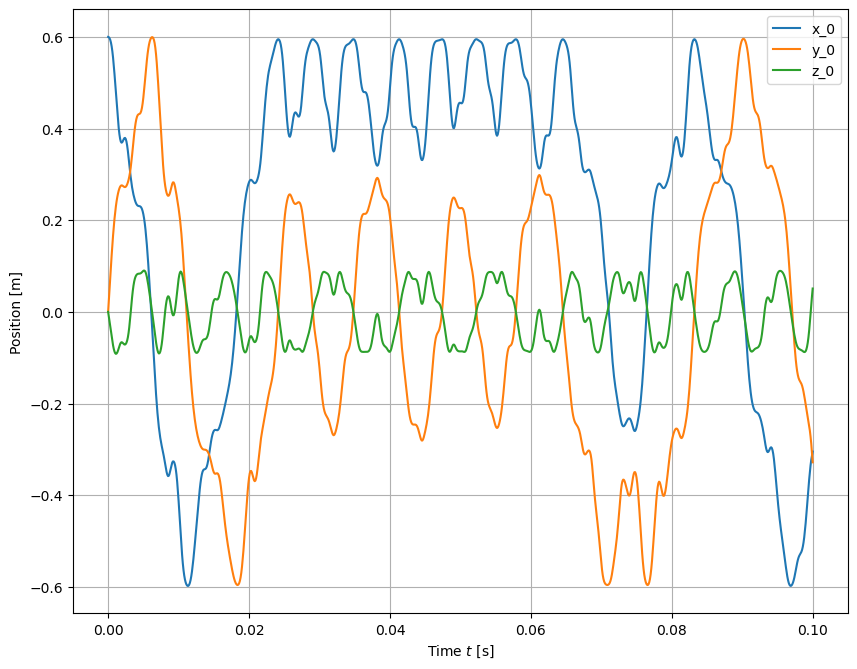

In [80]:
solution_electron.particletracker.plot_time_trajectories('xyz')

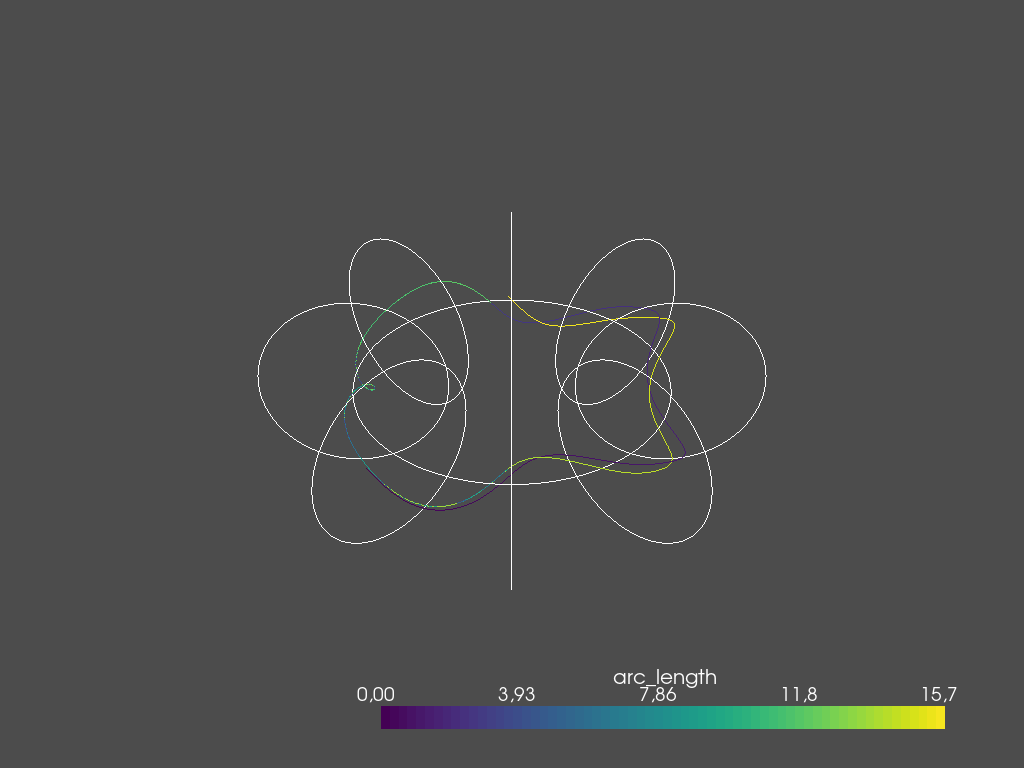

In [81]:
solution_electron.particletracker.visualize(plasma=c).show()

In [82]:
solution.particletracker.animate("toykamak_electron.mp4", solution.particle, nframes = 1000, notebook_display = True, plasma=c)